<a href="https://colab.research.google.com/github/hanhluukim/replication-topic-modelling-in-embedding-space/blob/main/notebook_replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Das Projekt aus dem Github klonen und in den Projektsordner**

In [ ]:
#wenn die Ordner noch nicht geklont ist, soll dieser Fehler zuerst durchgeführt werden.
!git clone https://github.com/hanhluukim/replication-topic-modelling-in-embedding-space.git

Cloning into 'replication-topic-modelling-in-embedding-space'...
remote: Enumerating objects: 1041, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 1041 (delta 79), reused 136 (delta 69), pack-reused 895
Receiving objects: 100% (1041/1041), 491.04 MiB | 30.17 MiB/s, done.
Resolving deltas: 100% (530/530), done.
Checking out files: 100% (110/110), done.


In [ ]:
cd /content/replication-topic-modelling-in-embedding-space

/content/replication-topic-modelling-in-embedding-space


#**Die benötige Paketen für das Projekt mittels requirements.txt installieren**



In [ ]:
# Falls die Packages noch nicht installiert wurden, 
!pip install -r "/content/replication-topic-modelling-in-embedding-space/requirements.txt"

     |████████████████████████████████| 4.2 MB 4.1 MB/s 
     |████████████████████████████████| 88 kB 6.6 MB/s 
     |████████████████████████████████| 28.8 MB 21.0 MB/s 
     |████████████████████████████████| 636 kB 55.1 MB/s 
     |████████████████████████████████| 79.9 MB 115 kB/s 
     |████████████████████████████████| 6.6 MB 36.0 MB/s 
     |████████████████████████████████| 84 kB 2.9 MB/s 
     |████████████████████████████████| 1.1 MB 50.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=5982d42883467b49432df08a22b78cccde380369f200a864febac6ae36ba55c5
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=8538c53846aabbd6eab5f20c2fa737746e54fa0bc74eedc49e98407c8c80543b
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successf

# **READme**
Die Teile, die aus dem `src` importieren wurden, werden in [hier:](https://github.com/hanhluukim/replication-topic-modelling-in-embedding-space/tree/main/src) implementieren



# **Gebrauchte Paketen importieren**

In [ ]:
# einige Paketten wurden für Visualisierung gebraucht
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import umap.umap_ as umap
import time
import plotly.express as px
from sklearn import cluster
from sklearn import metrics

# **Vorverarbeitung und BOW-Repräsentationen für Textdaten durchführen**
1. Vocabular erstellen
2. BOW-Repräsentationen für allen Teildatensätzen

In [ ]:
from src.prepare_dataset import TextDataLoader

In [ ]:
# init TextDataLoader für die Datenquelle 20 News Groups
# Daten abrufen vom Sklearn, tokenisieren und besondere Charaktern entfernen
textsloader = TextDataLoader(source="20newsgroups", train_size=None, test_size=None)
textsloader.load_tokenize_texts("20newsgroups")
# Beispiel von Textdaten
textsloader.show_example_raw_texts(n_docs=2)

loading texts: ...
train-size after loading: 11314
test-size after loading: 7532
finished load!
check some sample texts of the dataset after filter punctuation and digits
['From', ':', 'lerxst', '@', 'wam', '.', 'umd', '.', 'edu', '(', "where's", 'my', 'thing', ')', 'Subject', ':', 'WHAT', 'car', 'is', 'this', '!', '?', 'Nntp', 'Posting', 'Host', ':', 'rac3', '.', 'wam', '.', 'umd', '.', 'edu', 'Organization', ':', 'University', 'of', 'Maryland', ',', 'College', 'Park', 'Lines', ':', '15', 'I', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'I', 'saw', 'the', 'other', 'day', '.', 'It', 'was', 'a', '2', 'door', 'sports', 'car', ',', 'looked', 'to', 'be', 'from', 'the', 'late', '60s', '/', 'early', '70s', '.', 'It', 'was', 'called', 'a', 'Bricklin', '.', 'The', 'doors', 'were', 'really', 'small', '.', 'In', 'addition', ',', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', '.', 'This', 'is', 'all

In [ ]:
# Vorverarbeitung von Daten mit folgenden Schritten:
textsloader.preprocess_texts(length_one_remove=True, punctuation_lower = True, stopwords_filter = True)

start: preprocessing: ...
finised: preprocessing!


In [ ]:
# Daten zerlegen für Train, Test und Validation. Erstellen Vocabular aus dem Trainset
min_df=2
textsloader.split_and_create_voca_from_trainset(max_df=0.7, min_df=min_df, stopwords_remove_from_voca=True)

test-document-frequency: 
[[55 55  5 ...  2  2  3]]
vocab-size in df: 57326
validation-size ist: 0.01
start creating vocabulary ...
length of the vocabulary: 54318
sample ten words of the vocabulary: ['maritimes', 'niceties', 'pancreatic', 'sporting', 'lhx', 'farley', 'simd', 'ballgame', 'aflatoxin', 'goose']
length word2id list: 54318
length id2word list: 54318
finished: creating vocabulary


# **LDA Model**

Benutzen das fertige Paket von Gensim, um die Topics mit LDA zu finden: [LDA Model GENSIM](https://radimrehurek.com/gensim/models/ldamodel.html)
Die Coherence werden mit den Evaluationscoden von Autoren erstmal getesten

In [ ]:
#from src.evaluierung import topicCoherence
from src.lda import lda
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_numeric
from gensim.models.coherencemodel import CoherenceModel


# Erstellen BOW-Repräsentation für LDA Model
for_lda_model = True 
word2id, id2word, train_set, test_set, val_set = textsloader.create_bow_and_savebow_for_each_set(for_lda_model=for_lda_model)
gensim_corpus_train_set = train_set

docs_tr, docs_t, docs_v = textsloader.get_docs_in_words_for_each_set()
#lda model
print(100*"-")

ldamodel = lda(train_set,10,id2word)
lda_topics = ldamodel.show_topics(num_words=10)
topics = []
filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]
for topic in lda_topics:
    #print(topic)
    topics.append(preprocess_string(topic[1], filters))
for topic in topics:
  print(topic)
print(100*"-")
#tc = topicCoherence(topics,10,docs_tr,len(docs_tr))
#print(tc)

#----------using coherence from gensim-----
class DictObj:
  def __init__(self, word2id, id2word):
    self.id2token = id2word
    self.token2id = word2id

my_dict_obj = DictObj(word2id, id2word)
cm = CoherenceModel(topics=topics, texts = docs_tr, corpus = train_set, dictionary = my_dict_obj, coherence='u_mass')
print(f'coherrence from gensim: {cm.get_coherence()}')

train-size-after-all: 11214
test-size-after-all: 7532
validation-size-after-all: 100
length train-documents-indices : 1420825
length of the vocabulary: 54318


start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

compact representation for LDA
----------------------------------------------------------------------------------------------------
['amortization', 'critically', 'fundamental', 'residences', 'muttering', 'wurman', 'errolc', 'byoh', 'ergonomics', 'pathogenic']
['invective', 'kieth', 'displayable', 'ncrcae', 'surveyors', 'restricts', 'modimidofrsaso', 'staffers', 'fulness', 'residences']
['rjbaucom', 'countersteering', 'neisseria', 'federales', 'refresher', 'netlanders', 'fulness', 'ideally', 'bottome

# **Topic Coherrence of Authors**
1. Für Vergleich Ergebnisse zwischen eigener TC und TC von Authoren

In [ ]:
# erstelllen die Daten nach ETM-Format damit man Author Evaluation benutzen kann
word2id, id2word, train_set, test_set, val_set = textsloader.create_bow_and_savebow_for_each_set(for_lda_model=False)

train-size-after-all: 11214
test-size-after-all: 7532
validation-size-after-all: 100
length train-documents-indices : 1420825
length of the vocabulary: 54318


start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

some id2word befor saving: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [ ]:
import torch 
import numpy as np

def get_topic_diversity(beta, topk):
    num_topics = beta.shape[0]
    list_w = np.zeros((num_topics, topk))
    for k in range(num_topics):
        idx = beta[k,:].argsort()[-topk:][::-1]
        list_w[k,:] = idx
    n_unique = len(np.unique(list_w))
    TD = n_unique / (topk * num_topics)
    print('Topic diveristy is: {}'.format(TD))
    return TD

def get_document_frequency(data, wi, wj=None):
    if wj is None:
        D_wi = 0
        for l in range(len(data)):
            doc = data[l]#.squeeze(0)
            if len(doc) == 1: 
                continue
            else:
                doc = doc#.squeeze()
            if wi in doc:
                D_wi += 1
        return D_wi
    D_wj = 0
    D_wi_wj = 0
    for l in range(len(data)):
        doc = data[l]#.squeeze(0)
        """
        if len(doc) == 1: 
            doc = [doc.squeeze()]
        else:
            doc = doc.squeeze()
        """
        if wj in doc:
            D_wj += 1
            if wi in doc:
                D_wi_wj += 1
    return D_wj, D_wi_wj 

def get_topic_coherence(data, top10words_topics, word2id):
    #data should be document in word-ids
    D = len(data) ## number of docs...data is list of documents
    print('D: ', D)
    TC = []
    num_topics = len(top10words_topics)
    for k in range(num_topics):
        print('k: {}/{}'.format(k, num_topics))
        top_words = top10words_topics[k] #[vocab[a] for a in top_10]
        top_10 = [word2id[idx] for idx in top_words]
        TC_k = 0
        counter = 0
        for i, word_id in enumerate(top_10):
            # get D(w_i)
            D_wi = get_document_frequency(data, word_id)
            j = i + 1
            tmp = 0
            while j < len(top_10) and j > i:
                # get D(w_j) and D(w_i, w_j)
                D_wj, D_wi_wj = get_document_frequency(data, word_id, top_10[j])
                # get f(w_i, w_j)
                if D_wi_wj == 0:
                    f_wi_wj = -1
                else:
                    f_wi_wj = -1 + ( np.log(D_wi) + np.log(D_wj)  - 2.0 * np.log(D) ) / ( np.log(D_wi_wj) - np.log(D) )
                # update tmp: 
                tmp += f_wi_wj
                j += 1
                counter += 1
            # update TC_k
            TC_k += tmp 
        TC.append(TC_k)
    print('counter: ', counter)
    print('num topics: ', len(TC))
    TC = np.mean(TC) / counter
    print('Topic coherence is: {}'.format(TC))
    return TC



# **LDA-gelernte-Topics-Coherence-Ergebnis**

In [ ]:
#topic LDA but evlauation of authors coherence
top10words_topics = topics
get_topic_coherence(list(train_set['tokens']), top10words_topics, word2id)

D:  11214
k: 0/10
k: 1/10
k: 2/10
k: 3/10
k: 4/10
k: 5/10
k: 6/10
k: 7/10
k: 8/10
k: 9/10
counter:  45
num topics:  10
Topic coherence is: -0.9726848496909954


-0.9726848496909954

# **Data for ETM**



1.   Input Daten für der ersten Teil ETM ist (normalisierte)Bag-Of-Words-Repräsentation
2.   textsloader.create_bow_and_savebow_for_each_set(for_lda_model=True) stellt die folgenden Daten für das Modell:

*   word2id
*   id2word
*   train_set, test_set, val_set in der Form von BoW

In [ ]:
# Erstellen BOW-Repräsentation für ETM Modell
for_lda_model = False
word2id, id2word, train_set, test_set, val_set = textsloader.create_bow_and_savebow_for_each_set(for_lda_model=for_lda_model)

train-size-after-all: 11214
test-size-after-all: 7532
validation-size-after-all: 100
length train-documents-indices : 1420825
length of the vocabulary: 54318


start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

start: creating bow representation...
finised creating bow input!

some id2word befor saving: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


**Vocabular und IDs anzeigen als Beispiel**

---





In [ ]:
# show for samples: 100 word2id and id2 word
word2id_df_100 = pd.DataFrame()
word2id_df_100['word'] = list(word2id.keys())[:100]
word2id_df_100['id'] = list(word2id.values())[:100]
word2id_df_100

,word,id
0,maritimes,0
1,niceties,1
2,pancreatic,2
3,sporting,3
4,lhx,4
...,...,...
95,amp,95
96,remedy,96
97,govern,97
98,wis,98


**Die Größe von Datensätzen kontrollieren**

In [ ]:
# Kontrollieren die Größen von verschiedenen Datensätzen
print(f'Size of the vocabulary after prprocessing ist: {len(textsloader.vocabulary)}')
print(f'Size of train set: {len(train_set["tokens"])}')
print(f'Size of val set: {len(val_set["tokens"])}')
print(f'Size of test set: {len(test_set["test"]["tokens"])}')

Size of the vocabulary after prprocessing ist: 54318
Size of train set: 11214
Size of val set: 100
Size of test set: 7532


# **Word-Embedding-Teil**

**Dokumenten wiederstellen für Word2Vec Embedding**



1.   Da wir Embeddings für jedes Wort des Vocabulares (das Vocab nur aus dem Trainset) trainieren möchten, brauchen die Train_set (Dokumenten in Wörtern)
2.   Wir trainieren Wort-Embedding für jedes Wort mit Skipgram Methode (die Autoren benutzten Skipgram. Sie stellen nur über CBOW in dem Hintergrund vor, aber sie benutzen tatsächlich Skipgram)
3.   Trainierensetting = Word2Vec (siehe [Word2Vec-Tomas Mikolov](https://arxiv.org/pdf/1310.4546.pdf))



In [ ]:
# re-erstellen von Dokumenten nach der Vorverarbeitungen. Die Dokumenten sind in Wörtern und werden für Word-Embedding Training benutzt
docs_tr, docs_t, docs_v = textsloader.get_docs_in_words_for_each_set()
train_docs_df = pd.DataFrame()
train_docs_df['text-after-preprocessing'] = [' '.join(doc) for doc in docs_tr[:100]]
train_docs_df

,text-after-preprocessing
0,biochem nwu jackson swimming pool defense nntp...
1,goykhman apollo hp red herring police state us...
2,hades coos dartmouth brian hughes installing r...
3,jaeger buphy bu gregg jaeger inimitable rushdi...
4,sysmgr king eng umd doug mohney boom whoosh co...
...,...
95,rcampbel weejordy physics mun ca roderick camp...
96,jiml strauss ftcollinsco ncr jim sharp parts i...
97,sera zuma serdar argic nazi germany armenians ...
98,chips astro ocis temple charlie mathew bible r...


**Word-Embedding trainieren mit dem Traindatensatz und gespeichert für ETM später**

In [ ]:
from src.embedding import WordEmbeddingCreator
from pathlib import Path

save_path = Path.joinpath(Path.cwd(), f'prepared_data/min_df_{min_df}')
figures_path = Path.joinpath(Path.cwd(), f'figures/min_df_{min_df}')
Path(figures_path).mkdir(parents=True, exist_ok=True)

wb_creator = WordEmbeddingCreator(model_name="skipgram", documents = docs_tr, save_path= save_path)
wb_creator.train(min_count=0, embedding_size= 300)
vocab = list(word2id.keys())

train begin:word-embedding with skipgram
word-embedding train finished


In [ ]:
wb_creator.create_and_save_vocab_embedding(vocab, save_path)

length of vocabulary from word-embedding model 54318
length of the vocabulary of prepraring-dataset-vocabulary: 54318


100%|██████████| 54318/54318 [01:14<00:00, 725.82it/s]


True

**kurze Visualierung von Wortembeddings mit UMAP (UMAP werden die Embeddings zu 2D reduziert. KMeans wurden benutzen, um zu sehen, wie die Clusters von Wörtern aussehen - nur zu sehen, nicht zu dem Paper gehören)**

In [ ]:
wb_creator.cluster_words(save_path, figures_path, n_components=2, text = False)

train begin:word-embedding with skipgram
word-embedding train finished
length of vocabulary from word-embedding model 54318
length of the vocabulary of prepraring-dataset-vocabulary: 54318


100%|██████████| 54318/54318 [01:36<00:00, 560.75it/s]
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


True

**Testen ein paar Word-Embeddings and ähnliche semantische Wörter**

In [ ]:
v = list(wb_creator.model.wv.vocab)[0]
vec = list(wb_creator.model.wv.__getitem__(v))
print(f'word-embedding of the word-- {v}: ')
print(f'vector: {vec}')
print(f'dim of vector: {len(vec)}')

word-embedding of the word-- biochem: 
vector: [-0.14157833, 0.050990738, 0.014697294, -0.009218401, -0.15177213, -0.0844396, -0.060142864, 0.021053264, -0.057122238, 0.012421334, -0.076945595, -0.038574696, 0.060737833, -0.09431537, -0.15847237, 0.02679344, -0.108441725, -0.061066523, -0.01625552, 0.009843035, -0.11116822, 0.109681785, 0.10853204, -0.058395717, -0.03160111, 0.12871622, 0.012014183, -0.04834826, -0.1559453, 0.01970331, -0.02588785, -0.0867094, 0.044431128, -0.14973989, -0.048351754, 0.06663977, -0.027648615, 0.04418308, -0.15021908, -0.18707687, -0.032482862, 0.0074558896, 0.01715666, 0.12953727, -0.06493443, -0.0646555, 0.050468672, 0.0027788663, 0.12116511, -0.104778536, -0.14244778, -0.08758561, -0.07736175, 0.12347255, -0.07086609, 0.034628578, -0.1094819, 0.15872587, -0.004489091, 0.03234694, -0.07180933, -0.08486489, 0.028438311, 0.12439024, 0.050182965, 0.15937923, -0.03695727, -0.21966076, -0.08870257, -0.10223366, 0.037058797, -0.09844719, 0.05314422, -0.07963

In [ ]:
print("neighbor words of some sample selected words")
for i in range(0,5):
      print(f'neighbor of word {vocab[i]}')
      print([r[0] for r in wb_creator.find_most_similar_words(n_neighbor=5, word=vocab[i])])
      print([r[1] for r in wb_creator.find_most_similar_words(n_neighbor=5, word=vocab[i])])
      print(100*"-")

neighbor words of some sample selected words
neighbor of word contributors
['bunches', 'corroborated', 'corrections', 'informative', 'regularly']
[0.9480756521224976, 0.9479163885116577, 0.9412254095077515, 0.9400860071182251, 0.9391990900039673]
----------------------------------------------------------------------------------------------------
neighbor of word cyrus
['oppressed', 'severest', 'amid', 'carnage', 'deplorable']
[0.9568223357200623, 0.9552994966506958, 0.9531130194664001, 0.9524449110031128, 0.9518099427223206]
----------------------------------------------------------------------------------------------------
neighbor of word hanuman
['poori', 'barnesm', 'atsugi', 'penelope', 'thames']
[0.9641444683074951, 0.961155354976654, 0.9398401975631714, 0.9341317415237427, 0.9340910911560059]
----------------------------------------------------------------------------------------------------
neighbor of word vehemently
['dismissed', 'inaccuracies', 'vices', 'ingrained', 'fulfilme

# **ETM Model**

ETM hat die ähnliche Architektur eines Variational Autoencoders (Encoder für Sampling latent Repräsentation von Dokument) und (Decoder: eigenlich nur das Produkt von doc-over-topics und topic-over-vocabulary)

ETM wird mit den pretrainierten Embedding kombiniert. Die Embeddings für Topics werden als Gewichten eines Teiles des Netzes aktualiert mittels der negative-ELBO (Reconstruction-Loss + KLD Loss)

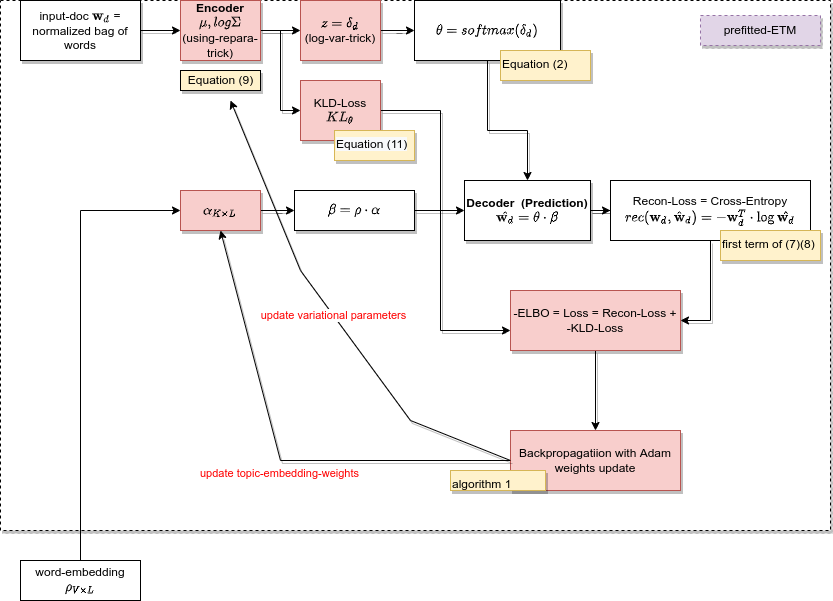


In [ ]:
# using DocSet to use easier the modul DataSet from torch
from src.train_etm import DocSet, TrainETM
from src.etm import ETM
import torch

vocab_size = len(list(word2id.keys()))
tr_set = DocSet("train", vocab_size, train_set, normalize_data=True)
print(f'number train-samples: {len(tr_set)}')
print(f'sum of sample vector: {sum(tr_set.__getitem__(0))}')
print(f'length of sample vector: {torch.norm(tr_set.__getitem__(0))}')

number train-samples: 11214
sum of sample vector: 0.9999997615814209
length of sample vector: 0.13754890859127045


**Trainingsparametern vorbereiten**




In [ ]:
class TrainArguments:
      def __init__(self, epochs, batch_size, log_interval):
          self.epochs = epochs
          self.batch_size = batch_size
          self.log_interval = log_interval

class OptimizerArguments:
      def __init__(self, optimizer_name, lr, wdecay):
            self.optimizer = optimizer_name
            self.lr = lr
            self.wdecay = wdecay
            
train_args = TrainArguments(epochs=15, batch_size=1000, log_interval=None)
optimizer_args = OptimizerArguments(optimizer_name="adam", lr=0.002, wdecay=0.0000012)
print(train_args.epochs)
print(optimizer_args.optimizer)

from src.embedding import read_prefitted_embedding
embedding_data = read_prefitted_embedding(vocab, save_path)
num_topics = 10
t_hidden_size = 800
rho_size = len(embedding_data[0])
emb_size = len(embedding_data[0])
theta_act = "tanh"

15
adam


# **ETM mit Cross-Entropy**

ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): Tanh()
  (topic_embeddings_alphas): Linear(in_features=300, out_features=10, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=54318, out_features=800, bias=True)
    (1): Tanh()
    (2): Linear(in_features=800, out_features=800, bias=True)
    (3): Tanh()
  )
  (mu_q_theta): Linear(in_features=800, out_features=10, bias=True)
  (logsigma_q_theta): Linear(in_features=800, out_features=10, bias=True)
)
number of batches: 11
Epoch: 1/15  -  Loss: 10.72652 	 Rec: 10.72478 	 KL: 0.00175
Epoch: 2/15  -  Loss: 10.43805 	 Rec: 10.43772 	 KL: 0.00033
Epoch: 3/15  -  Loss: 10.17044 	 Rec: 10.17029 	 KL: 0.00015
Epoch: 4/15  -  Loss: 9.93934 	 Rec: 9.93926 	 KL: 8e-05
Epoch: 5/15  -  Loss: 9.76021 	 Rec: 9.76014 	 KL: 6e-05
Epoch: 6/15  -  Loss: 9.64246 	 Rec: 9.64239 	 KL: 7e-05
Epoch: 7/15  -  Loss: 9.56677 	 Rec: 9.56668 	 KL: 9e-05
Epoch: 8/15  -  Loss: 9.51275 	 Rec: 9.51264 	 KL: 0.00011
Epoch: 9/15  -  Loss: 9.47

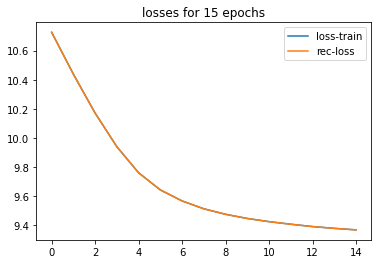

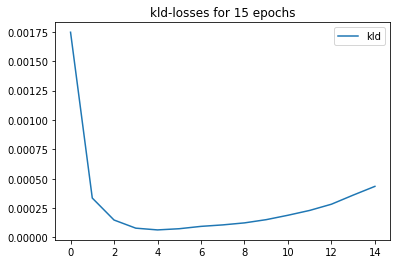

tensor([1.7698e-05, 5.6199e-06, 7.8378e-06,  ..., 7.6409e-06, 3.8307e-06,
        6.3544e-06])
tensor(1.0000)
[('nntp', 0.010554145090281963), ('host', 0.009665240533649921), ('university', 0.008242351934313774), ('dos', 0.0065311468206346035), ('posting', 0.006367343477904797), ('scsi', 0.0051118661649525166), ('ca', 0.003947131335735321), ('cc', 0.003015408758074045), ('cleveland', 0.0026594498194754124), ('cs', 0.0026275115087628365)]
[('dos', 0.008425111882388592), ('scsi', 0.006047905422747135), ('nntp', 0.005436430685222149), ('host', 0.004735258407890797), ('disk', 0.0034579725470393896), ('posting', 0.0030476711690425873), ('god', 0.0027458288241177797), ('hockey', 0.0024661854840815067), ('encryption', 0.0023582244757562876), ('chip', 0.0023544549476355314)]
[('dos', 0.008580686524510384), ('nntp', 0.007073138374835253), ('scsi', 0.0059983935207128525), ('host', 0.005640181712806225), ('posting', 0.00393117219209671), ('disk', 0.0033600127790123224), ('windows', 0.002449861494

In [ ]:
#--------------------------training----------------------------------------------------
#del etm_model
# define the ETM-model with setting-parameters
etm_model = ETM(
      num_topics, 
      vocab_size, 
      t_hidden_size, rho_size, emb_size, theta_act, 
      embedding_data, 
      enc_drop=0.5)

print(etm_model)

loss_name = "cross-entropy"

train_class = TrainETM().train(
    etm_model,
    loss_name,
    vocab_size, 
    train_args, optimizer_args, train_set,
    normalize_data = True,
    figures_path = figures_path)
    #num_topics, t_hidden_size, rho_size, emb_size, theta_act,  embedding_data, 0.5)

#-------------------show topics
topics = etm_model.show_topics(id2word, 10)
for tp in topics:
  print(tp)

In [ ]:
#-------------------show topics
topics = etm_model.show_topics(id2word, 10)
topics = [[e[0] for e in tp] for tp in topics] #get only top words
for tp in topics:
  print(tp)
get_topic_coherence(list(train_set['tokens']), topics, word2id)


tensor([1.7698e-05, 5.6199e-06, 7.8378e-06,  ..., 7.6409e-06, 3.8307e-06,
        6.3544e-06])
tensor(1.0000)
['nntp', 'host', 'university', 'dos', 'posting', 'scsi', 'ca', 'cc', 'cleveland', 'cs']
['dos', 'scsi', 'nntp', 'host', 'disk', 'posting', 'god', 'hockey', 'encryption', 'chip']
['dos', 'nntp', 'scsi', 'host', 'posting', 'disk', 'windows', 'hockey', 'encryption', 'card']
['writes', 'article', 'university', 'nntp', 'host', 'cs', 'distribution', 'posting', 'netcom', 'cc']
['nntp', 'host', 'scsi', 'dos', 'university', 'posting', 'cs', 'ca', 'cc', 'distribution']
['host', 'writes', 'nntp', 'article', 'posting', 'cs', 'scsi', 'university', 'cc', 'dos']
['nntp', 'host', 'cs', 'writes', 'posting', 'ca', 'scsi', 'university', 'article', 'dos']
['dos', 'nntp', 'scsi', 'host', 'ca', 'disk', 'posting', 'god', 'hockey', 'nasa']
['nntp', 'university', 'host', 'posting', 'scsi', 'dos', 'ohio', 'cc', 'cs', 'cleveland']
['dos', 'scsi', 'nntp', 'host', 'god', 'disk', 'posting', 'ca', 'encryptio

0.061350516765890616

**Entropy-Loss mit anderen activation function**

ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (topic_embeddings_alphas): Linear(in_features=300, out_features=10, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=54318, out_features=800, bias=True)
    (1): ReLU()
    (2): Linear(in_features=800, out_features=800, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=800, out_features=10, bias=True)
  (logsigma_q_theta): Linear(in_features=800, out_features=10, bias=True)
)
number of batches: 11
Epoch: 1/15  -  Loss: 10.69664 	 Rec: 10.69597 	 KL: 0.00067
Epoch: 2/15  -  Loss: 10.40817 	 Rec: 10.40814 	 KL: 4e-05
Epoch: 3/15  -  Loss: 10.1426 	 Rec: 10.14258 	 KL: 2e-05
Epoch: 4/15  -  Loss: 9.91718 	 Rec: 9.91716 	 KL: 2e-05
Epoch: 5/15  -  Loss: 9.74693 	 Rec: 9.7469 	 KL: 3e-05
Epoch: 6/15  -  Loss: 9.63468 	 Rec: 9.63463 	 KL: 5e-05
Epoch: 7/15  -  Loss: 9.56079 	 Rec: 9.56073 	 KL: 6e-05
Epoch: 8/15  -  Loss: 9.51101 	 Rec: 9.51092 	 KL: 8e-05
Epoch: 9/15  -  Loss: 9.47192 	 Re

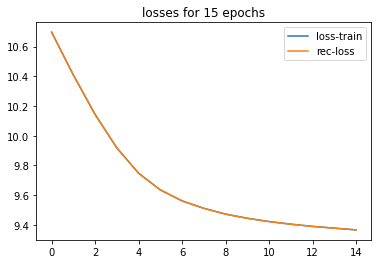

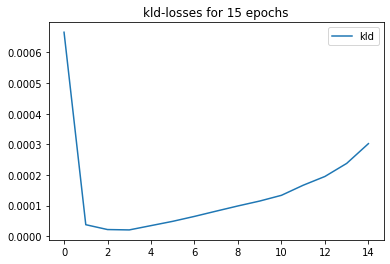

tensor([6.6059e-06, 6.8112e-06, 5.8702e-06,  ..., 5.8733e-06, 5.1189e-06,
        1.3183e-03])
tensor(1.0000)
[('host', 0.008175169117748737), ('nntp', 0.007725934963673353), ('university', 0.007054362446069717), ('ca', 0.0058625563979148865), ('cs', 0.005749586503952742), ('scsi', 0.004834688268601894), ('dos', 0.0047651175409555435), ('posting', 0.004523307550698519), ('computer', 0.0034447070211172104), ('ohio', 0.0034041935577988625)]
[('article', 0.008790328167378902), ('host', 0.00869267899543047), ('nntp', 0.007871138863265514), ('university', 0.006504601798951626), ('writes', 0.006415793672204018), ('cs', 0.006300373934209347), ('scsi', 0.0052500441670417786), ('ca', 0.00517835421487689), ('distribution', 0.00507949385792017), ('posting', 0.004544868599623442)]
[('host', 0.006751211825758219), ('ca', 0.006004110909998417), ('nntp', 0.005809611175209284), ('scsi', 0.00426038121804595), ('posting', 0.004130843095481396), ('dos', 0.0039223479107022285), ('cs', 0.003314441535621881

In [ ]:
del train_args
del optimizer_args

train_args = TrainArguments(epochs=15, batch_size=1000, log_interval=None)
optimizer_args = OptimizerArguments(optimizer_name="adam", lr=0.002, wdecay=0.0000012)

from src.embedding import read_prefitted_embedding
embedding_data = read_prefitted_embedding(vocab, save_path)
num_topics = 10
t_hidden_size = 800
rho_size = len(embedding_data[0])
emb_size = len(embedding_data[0])
theta_act = "ReLU"

del etm_model
del train_class

etm_model = ETM(
      num_topics, 
      vocab_size, 
      t_hidden_size, rho_size, emb_size, theta_act, 
      embedding_data, 
      enc_drop=0.5)

print(etm_model)

#--------------------------training----------------------------------------------------
loss_name = "cross-entropy"

train_class = TrainETM().train(
    etm_model,
    loss_name,
    vocab_size, 
    train_args, optimizer_args, train_set,
    normalize_data = True,
    figures_path = figures_path)
    #num_topics, t_hidden_size, rho_size, emb_size, theta_act,  embedding_data, 0.5)

#-------------------show topics
topics = etm_model.show_topics(id2word, 10)
for tp in topics:
  print(tp)

#-------------------show topics
topics = etm_model.show_topics(id2word, 10)
topics = [[e[0] for e in tp] for tp in topics] #get only top words
for tp in topics:
  print(tp)
get_topic_coherence(list(train_set['tokens']), topics, word2id)
del etm_model
del train_class

# **ETM-other-loss wie im Paper**

In [ ]:
# define the ETM-model with setting-parameters
del etm_model
del train_class

In [ ]:
etm_model = ETM(
      num_topics, 
      vocab_size, 
      t_hidden_size, rho_size, emb_size, theta_act, 
      embedding_data, 
      enc_drop=0.5)

print(etm_model)

ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): Tanh()
  (topic_embeddings_alphas): Linear(in_features=300, out_features=10, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=54318, out_features=800, bias=True)
    (1): Tanh()
    (2): Linear(in_features=800, out_features=800, bias=True)
    (3): Tanh()
  )
  (mu_q_theta): Linear(in_features=800, out_features=10, bias=True)
  (logsigma_q_theta): Linear(in_features=800, out_features=10, bias=True)
)


**trainieren**

number of batches: 11
Epoch: 1/15  -  Loss: 589335.9375 	 Rec: 589335.875 	 KL: 0.029
Epoch: 2/15  -  Loss: 589335.4375 	 Rec: 589335.4375 	 KL: 0.03311
Epoch: 3/15  -  Loss: 589335.25 	 Rec: 589335.25 	 KL: 0.01993
Epoch: 4/15  -  Loss: 589334.625 	 Rec: 589334.625 	 KL: 0.0246
Epoch: 5/15  -  Loss: 589335.25 	 Rec: 589335.25 	 KL: 0.03683
Epoch: 6/15  -  Loss: 589335.1875 	 Rec: 589335.125 	 KL: 0.03552
Epoch: 7/15  -  Loss: 589335.875 	 Rec: 589335.875 	 KL: 0.02383
Epoch: 8/15  -  Loss: 589336.3125 	 Rec: 589336.25 	 KL: 0.06739
Epoch: 9/15  -  Loss: 589336.375 	 Rec: 589336.3125 	 KL: 0.04006
Epoch: 10/15  -  Loss: 589336.1875 	 Rec: 589336.125 	 KL: 0.03483
Epoch: 11/15  -  Loss: 589337.375 	 Rec: 589337.25 	 KL: 0.04962
Epoch: 12/15  -  Loss: 589336.8125 	 Rec: 589336.6875 	 KL: 0.17909
Epoch: 13/15  -  Loss: 589336.4375 	 Rec: 589336.4375 	 KL: 0.02801
Epoch: 14/15  -  Loss: 589336.375 	 Rec: 589336.25 	 KL: 0.077
Epoch: 15/15  -  Loss: 589337.875 	 Rec: 589337.6875 	 KL: 0.121

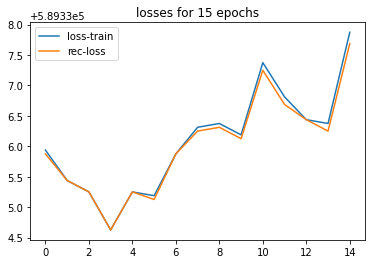

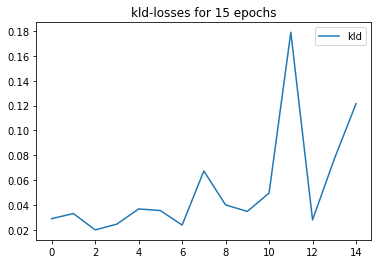

tensor([1.8428e-05, 1.8405e-05, 1.8397e-05,  ..., 1.8419e-05, 1.8430e-05,
        1.8358e-05])
tensor(0.9998)
[('day', 2.016268263105303e-05), ('list', 1.9713017536560073e-05), ('john', 1.9682829588418826e-05), ('good', 1.9650255126180127e-05), ('andrew', 1.953052014869172e-05), ('cmu', 1.940053334692493e-05), ('windows', 1.9331815565237775e-05), ('university', 1.932454870257061e-05), ('time', 1.93021769518964e-05), ('question', 1.9259412511019036e-05)]
[('years', 2.006276736210566e-05), ('system', 2.004399175348226e-05), ('good', 1.9762932424782775e-05), ('columbia', 1.9464787328615785e-05), ('work', 1.941597838595044e-05), ('case', 1.9397770302020945e-05), ('cs', 1.929748941620346e-05), ('appears', 1.9282122593722306e-05), ('nntp', 1.924671778397169e-05), ('man', 1.924140269693453e-05)]
[('file', 1.964777402463369e-05), ('michael', 1.9412633264437318e-05), ('find', 1.940061520144809e-05), ('hard', 1.938853347382974e-05), ('question', 1.9363447790965438e-05), ('mit', 1.925510150613263

In [ ]:
#--------------------------training----------------------------------------------------
loss_name = "paper-loss"

train_class = TrainETM().train(
    etm_model,
    loss_name,
    vocab_size, 
    train_args, optimizer_args, train_set,
    normalize_data = True,
    figures_path = figures_path)
    #num_topics, t_hidden_size, rho_size, emb_size, theta_act,  embedding_data, 0.5)

#-------------------show topics
topics = etm_model.show_topics(id2word, 10)
for tp in topics:
  print(tp)

#----------------
#from src.visualization import show_embedding_with_kmeans_umap
#show_embedding_with_kmeans_umap(
#    id2word, embedding_data, num_topics, etm_model.topic_embeddings_alphas.weight,
#    figures_path)

In [ ]:
#-------------------show topics
topics = etm_model.show_topics(id2word, 10)
topics = [[e[0] for e in tp] for tp in topics] #get only top words
for tp in topics:
  print(tp)
get_topic_coherence(list(train_set['tokens']), topics, word2id)


tensor([1.8428e-05, 1.8405e-05, 1.8397e-05,  ..., 1.8419e-05, 1.8430e-05,
        1.8358e-05])
tensor(0.9998)
['day', 'list', 'john', 'good', 'andrew', 'cmu', 'windows', 'university', 'time', 'question']
['years', 'system', 'good', 'columbia', 'work', 'case', 'cs', 'appears', 'nntp', 'man']
['file', 'michael', 'find', 'hard', 'question', 'mit', 'state', 'jim', 'system', 'netcom']
['world', 'problem', 'writes', 'state', 'david', 'question', 'system', 'cmu', 'reply', 'chip']
['mit', 'hp', 'article', 'isc', 'technology', 'pitt', 'problem', 'col', 'power', 'software']
['article', 'cc', 'world', 'bill', 'david', 'mail', 'states', 'adam', 'mark', 'ago']
['sun', 'att', 'distribution', 'research', 'space', 'colorado', 'writes', 'cmu', 'drive', 'andrew']
['host', 'nntp', 'years', 'sun', 'code', 'program', 'hp', 'windows', 'government', 'gm']
['world', 'hp', 'mit', 'mil', 'time', 'data', 'high', 'bit', 'cc', 'keith']
['university', 'power', 'care', 'nntp', 'sgi', 'ibm', 'jon', 'institute', 'repl

0.054993788712571434

**Other Activation function für Paper-Loss**

15
adam
ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (topic_embeddings_alphas): Linear(in_features=300, out_features=10, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=54318, out_features=800, bias=True)
    (1): ReLU()
    (2): Linear(in_features=800, out_features=800, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=800, out_features=10, bias=True)
  (logsigma_q_theta): Linear(in_features=800, out_features=10, bias=True)
)
number of batches: 11
Epoch: 1/15  -  Loss: 589336.0625 	 Rec: 589336.0 	 KL: 0.02637
Epoch: 2/15  -  Loss: 589335.1875 	 Rec: 589335.1875 	 KL: 0.01769
Epoch: 3/15  -  Loss: 589334.8125 	 Rec: 589334.8125 	 KL: 0.01161
Epoch: 4/15  -  Loss: 589335.5625 	 Rec: 589335.5625 	 KL: 0.01362
Epoch: 5/15  -  Loss: 589335.0625 	 Rec: 589335.0625 	 KL: 0.00359
Epoch: 6/15  -  Loss: 589335.4375 	 Rec: 589335.4375 	 KL: 0.0022
Epoch: 7/15  -  Loss: 589336.25 	 Rec: 589336.25 	 KL: 0.0033
Epoch: 8/15  -  Loss: 589335

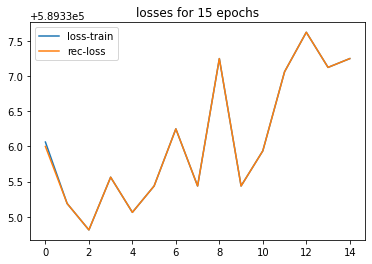

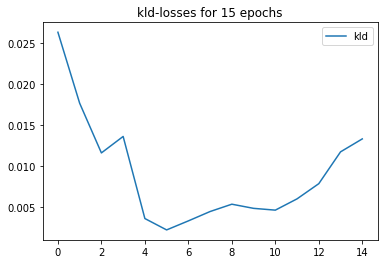

tensor([1.8400e-05, 1.8411e-05, 1.8401e-05,  ..., 1.8424e-05, 1.8429e-05,
        1.8373e-05])
tensor(1.0000)
[('case', 1.951966987689957e-05), ('writes', 1.949927354871761e-05), ('michael', 1.9383174731046893e-05), ('ibm', 1.9315870304126292e-05), ('andrew', 1.9281556888017803e-05), ('nntp', 1.9160675947205164e-05), ('net', 1.914096537802834e-05), ('ai', 1.9094240997219458e-05), ('tek', 1.9081075151916593e-05), ('single', 1.907881596707739e-05)]
[('world', 2.00306749320589e-05), ('thing', 1.9781917217187583e-05), ('isc', 1.9476956367725506e-05), ('smith', 1.944117684615776e-05), ('david', 1.9324883396620862e-05), ('today', 1.9316190446261317e-05), ('single', 1.9273975340183824e-05), ('mil', 1.927279299707152e-05), ('br', 1.9257191524957307e-05), ('colorado', 1.918588714033831e-05)]
[('sgi', 1.96531655092258e-05), ('white', 1.9405331840971485e-05), ('drive', 1.9328450434841216e-05), ('ibm', 1.9317127225804143e-05), ('jon', 1.9246295778430067e-05), ('reply', 1.9214878193452023e-05), ('s

0.06707760555112328

In [ ]:
del train_args
del optimizer_args

train_args = TrainArguments(epochs=15, batch_size=1000, log_interval=None)
optimizer_args = OptimizerArguments(optimizer_name="adam", lr=0.002, wdecay=0.0000012)
print(train_args.epochs)
print(optimizer_args.optimizer)

from src.embedding import read_prefitted_embedding
embedding_data = read_prefitted_embedding(vocab, save_path)
num_topics = 10
t_hidden_size = 800
rho_size = len(embedding_data[0])
emb_size = len(embedding_data[0])
theta_act = "ReLU"

# define the ETM-model with setting-parameters
del etm_model
del train_class

etm_model = ETM(
      num_topics, 
      vocab_size, 
      t_hidden_size, rho_size, emb_size, theta_act, 
      embedding_data, 
      enc_drop=0.5)

print(etm_model)

#--------------------------training----------------------------------------------------
loss_name = "paper-loss"

train_class = TrainETM().train(
    etm_model,
    loss_name,
    vocab_size, 
    train_args, optimizer_args, train_set,
    normalize_data = True,
    figures_path = figures_path)
    #num_topics, t_hidden_size, rho_size, emb_size, theta_act,  embedding_data, 0.5)

#-------------------show topics
topics = etm_model.show_topics(id2word, 10)
for tp in topics:
  print(tp)

#-------------------show topics
topics = etm_model.show_topics(id2word, 10)
topics = [[e[0] for e in tp] for tp in topics] #get only top words
for tp in topics:
  print(tp)
get_topic_coherence(list(train_set['tokens']), topics, word2id)


**Benutzung anderer Wert für Weight-Decay**

ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (topic_embeddings_alphas): Linear(in_features=300, out_features=10, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=54318, out_features=800, bias=True)
    (1): ReLU()
    (2): Linear(in_features=800, out_features=800, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=800, out_features=10, bias=True)
  (logsigma_q_theta): Linear(in_features=800, out_features=10, bias=True)
)
number of batches: 11
Epoch: 1/15  -  Loss: 589336.0625 	 Rec: 589336.0 	 KL: 0.02358
Epoch: 2/15  -  Loss: 589335.25 	 Rec: 589335.25 	 KL: 0.0144
Epoch: 3/15  -  Loss: 589334.9375 	 Rec: 589334.9375 	 KL: 0.00407
Epoch: 4/15  -  Loss: 589334.625 	 Rec: 589334.625 	 KL: 0.00355
Epoch: 5/15  -  Loss: 589334.5 	 Rec: 589334.5 	 KL: 0.00468
Epoch: 6/15  -  Loss: 589335.8125 	 Rec: 589335.8125 	 KL: 0.00957
Epoch: 7/15  -  Loss: 589335.0625 	 Rec: 589335.0625 	 KL: 0.02396
Epoch: 8/15  -  Loss: 589335.4375 	 Rec: 58

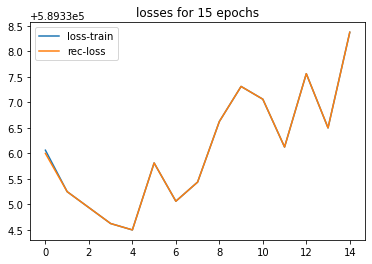

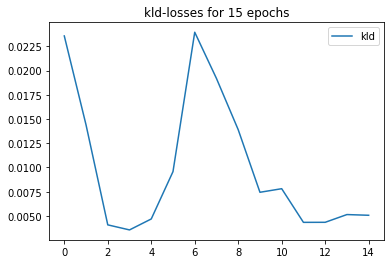

tensor([1.8428e-05, 1.8396e-05, 1.8403e-05,  ..., 1.8415e-05, 1.8397e-05,
        1.8345e-05])
tensor(1.0002)
[('article', 1.978362342924811e-05), ('ca', 1.9546023395378143e-05), ('good', 1.9474115106277168e-05), ('version', 1.9418248484726064e-05), ('list', 1.936290573212318e-05), ('high', 1.9333145246491767e-05), ('group', 1.931035512825474e-05), ('cmu', 1.925804463098757e-05), ('college', 1.9192806576029398e-05), ('de', 1.9153359971824102e-05)]
[('power', 2.0695826606242917e-05), ('cc', 2.0074137864867225e-05), ('au', 1.9760145733016543e-05), ('appears', 1.9741837604669854e-05), ('windows', 1.9605111447162926e-05), ('cs', 1.9602677639340982e-05), ('max', 1.9442237316980027e-05), ('world', 1.937625893333461e-05), ('info', 1.9358722056495026e-05), ('frank', 1.931070255523082e-05)]
[('org', 1.9639388483483344e-05), ('world', 1.9503486328176223e-05), ('hp', 1.9411645553191192e-05), ('number', 1.9352433810126968e-05), ('writes', 1.9278519175713882e-05), ('washington', 1.9268609321443364e

0.05862065774470134

In [ ]:
del train_args
del optimizer_args

train_args = TrainArguments(epochs=15, batch_size=1000, log_interval=None)
optimizer_args = OptimizerArguments(optimizer_name="adam", lr=0.002, wdecay=0.01)

from src.embedding import read_prefitted_embedding
embedding_data = read_prefitted_embedding(vocab, save_path)
num_topics = 10
t_hidden_size = 800
rho_size = len(embedding_data[0])
emb_size = len(embedding_data[0])
theta_act = "ReLU"

# define the ETM-model with setting-parameters
del etm_model
del train_class

etm_model = ETM(
      num_topics, 
      vocab_size, 
      t_hidden_size, rho_size, emb_size, theta_act, 
      embedding_data, 
      enc_drop=0.5)

print(etm_model)

#--------------------------training----------------------------------------------------
loss_name = "paper-loss"

train_class = TrainETM().train(
    etm_model,
    loss_name,
    vocab_size, 
    train_args, optimizer_args, train_set,
    normalize_data = True,
    figures_path = figures_path)
    #num_topics, t_hidden_size, rho_size, emb_size, theta_act,  embedding_data, 0.5)

#-------------------show topics
topics = etm_model.show_topics(id2word, 10)
for tp in topics:
  print(tp)

#-------------------show topics
topics = etm_model.show_topics(id2word, 10)
topics = [[e[0] for e in tp] for tp in topics] #get only top words
for tp in topics:
  print(tp)
get_topic_coherence(list(train_set['tokens']), topics, word2id)


# **epochs 100**

In [ ]:
del etm_model
del train_class

# define the ETM-model with setting-parameters
etm_model = ETM(
      num_topics, 
      vocab_size, 
      t_hidden_size, rho_size, emb_size, theta_act, 
      embedding_data, 
      enc_drop=0.5)

print(etm_model)
#--------------------------training----------------------------------------------------
loss_name = "paper-loss"
train_args = TrainArguments(epochs=100, batch_size=1000, log_interval=None)
train_class = TrainETM().train(
    etm_model,
    loss_name,
    vocab_size, 
    train_args, optimizer_args, train_set,
    normalize_data = True,
    figures_path = figures_path)
    #num_topics, t_hidden_size, rho_size, emb_size, theta_act,  embedding_data, 0.5)

#-------------------show topics
topics = etm_model.show_topics(id2word, 10)
for tp in topics:
  print(tp)
#-------------------show topics
topics = etm_model.show_topics(id2word, 10)
topics = [[e[0] for e in tp] for tp in topics] #get only top words
for tp in topics:
  print(tp)
get_topic_coherence(list(train_set['tokens']), topics, word2id)
